In [1]:
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score

In [2]:
class SummarizedCluster:
    def __init__(self, sum, sumsq=None, n=None):
        assert not n or n <= 150, 'n must be <= 150'
        if sumsq is None and n is None:
            self.sum = sum
            self.sumsq = sum ** 2
            self.n = 1
        else:
            self.sum = sum
            self.sumsq = sumsq
            self.n = n

    def __add__(self, other):
        s = SummarizedCluster(0)
        s += other
        return s

    def __iadd__(self, other):
        if isinstance(other, SummarizedCluster):
            self.sum += other.sum
            self.sumsq += other.sumsq
            self.n += other.n
        elif isinstance(other, np.ndarray):
            self.sum += other
            self.sumsq += other ** 2
            self.n += 1
        return self

    def centroid(self):
        return self.sum / self.n

    def var(self):
        return self.sumsq / self.n - self.centroid() ** 2

    def std(self):
        return np.sqrt(self.var())


def batch_cluster(batch):
    dbscan = DBSCAN(eps=0.5, min_samples=5).fit(batch)
    return dbscan.labels_


def as_clusters(points, labels):
    return list(map(lambda c_stats: SummarizedCluster(*c_stats),
                    map(lambda c_points: (sum(c_points), sum(c_points ** 2), len(c_points)),
                        map(lambda label: points[labels == label], np.unique(labels)))))


class BFR:
    def __init__(self):
        self.DS = []
        self.CS = []
        self.RS = []

    def absorb_points(self, points, d, threshold=2):
        absorbed = np.zeros(len(points), dtype=bool)

        centroids = np.array([c.centroid() for c in self.DS])
        stds = np.array([c.std() for c in self.DS]) + 1e-10

        for j, point in enumerate(points):
            if absorbed[j]: continue

            norm = (point - centroids) / stds
            mahalanobis = np.sqrt(np.sum(norm ** 2, axis=1))

            min_dist, min_idx = np.min(mahalanobis), np.argmin(mahalanobis)

            if min_dist < threshold * d ** .5:
                self.DS[min_idx] += point
                absorbed[j] = True

        return points[~absorbed]

    def merge_close_clusters(self, threshold=.2):
        merged = np.zeros(len(self.CS), dtype=bool)

        for i, c1 in enumerate(self.CS):
            if merged[i]: continue
            for j, c2 in enumerate(self.CS[i:], start=i):
                if merged[j]: continue
                if np.max((c1 + c2).var()) < threshold:
                    c1 += c2
                    merged[j] = True

        self.CS = self.CS[~merged]

    def merge_to_closest(self):
        clusters = self.DS.copy()
        centroids = np.array([c.centroid() for c in clusters])
        remaining = np.concat([self.CS, list(map(SummarizedCluster, self.RS))])

        for cluster in remaining:
            distances = np.linalg.norm(centroids - cluster.centroid(), axis=1)
            min_idx = np.argmin(distances)
            clusters[min_idx] += cluster

        return clusters

    def __call__(self, data, initial_centroids):
        k, d = initial_centroids.shape
        self.DS = list(map(SummarizedCluster, initial_centroids))
        self.CS = np.empty(0)
        self.RS = np.empty((0, d))

        for batch in data:
            batch = np.array(batch)

            batch = self.absorb_points(batch, d)
            batch = np.concat([batch, self.RS])

            labels = batch_cluster(batch)
            isolated = labels == -1
            nCS = as_clusters(batch[~isolated], labels[~isolated])

            self.RS = batch[isolated]
            self.CS = np.concat([self.CS, nCS])

            self.merge_close_clusters()

        clusters = self.merge_to_closest()

        return [c.centroid() for c in clusters], [c.n for c in clusters]

In [3]:
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target

X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [4]:
k = 3

initial_centroids = X.sample(n=3, random_state=42)

display('Initial Centroids:', initial_centroids)

'Initial Centroids:'

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
73,6.1,2.8,4.7,1.2
18,5.7,3.8,1.7,0.3
118,7.7,2.6,6.9,2.3


In [5]:
bfr = BFR()

batches = np.array_split(X.sample(frac=1, random_state=42), 5)

start_time = time.perf_counter()
bfr_centroids, bfr_counts = bfr(batches, initial_centroids.values)
bfr_time = time.perf_counter() - start_time

print(f'BFR Clustering Time: {bfr_time:.4f} seconds')
print('BFR Centroids:', *bfr_centroids, sep='\n')
print('BFR Counts:', *bfr_counts)

BFR Clustering Time: 0.0075 seconds
BFR Centroids:
[6.08735632 2.82643678 4.68965517 1.6       ]
[5.01960784 3.43529412 1.46666667 0.24705882]
[7.36       3.11333333 6.28       2.12666667]
BFR Counts: 87 51 15


/opt/homebrew/anaconda3/envs/deep-learning/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [6]:
def assign_labels(points, centroids):
    distances = np.linalg.norm(points[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)


bfr_labels = assign_labels(X.values, bfr_centroids)

bfr_ari = adjusted_rand_score(y, bfr_labels)

print(f'BFR Adjusted Rand Index: {bfr_ari:.4f}')

BFR Adjusted Rand Index: 0.6051


In [7]:
covariance_types = ['full', 'diag', 'tied']

gmm_results = {}

for cov_type in covariance_types:
    gmm = GaussianMixture(n_components=k, covariance_type=cov_type, random_state=42)

    start_time = time.perf_counter()
    gmm.fit(X)
    gmm_time = time.perf_counter() - start_time

    gmm_labels = gmm.predict(X)

    gmm_ari = adjusted_rand_score(y, gmm_labels)

    gmm_results[cov_type] = {'ARI': gmm_ari, 'Time': gmm_time, 'Labels': gmm_labels}

    print(f'GMM ({cov_type}) - ARI: {gmm_ari:.4f}, Time: {gmm_time:.4f} seconds')

GMM (full) - ARI: 0.9039, Time: 0.0494 seconds
GMM (diag) - ARI: 0.7445, Time: 0.0026 seconds
GMM (tied) - ARI: 0.8857, Time: 0.0031 seconds


In [8]:
results = {
    'BFR': {'ARI': bfr_ari, 'Time': bfr_time, 'Labels': bfr_labels},
}

for cov_type, metrics in gmm_results.items():
    method_name = f'GMM ({cov_type})'
    results[method_name] = metrics

results_df = pd.DataFrame(results).T.reset_index()
results_df.columns = ['Method', 'ARI', 'Time', 'Labels']

results_df

,Method,ARI,Time,Labels
0,BFR,0.605104,0.00747,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,GMM (full),0.903874,0.049377,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,GMM (diag),0.744526,0.002643,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,GMM (tied),0.885697,0.003072,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


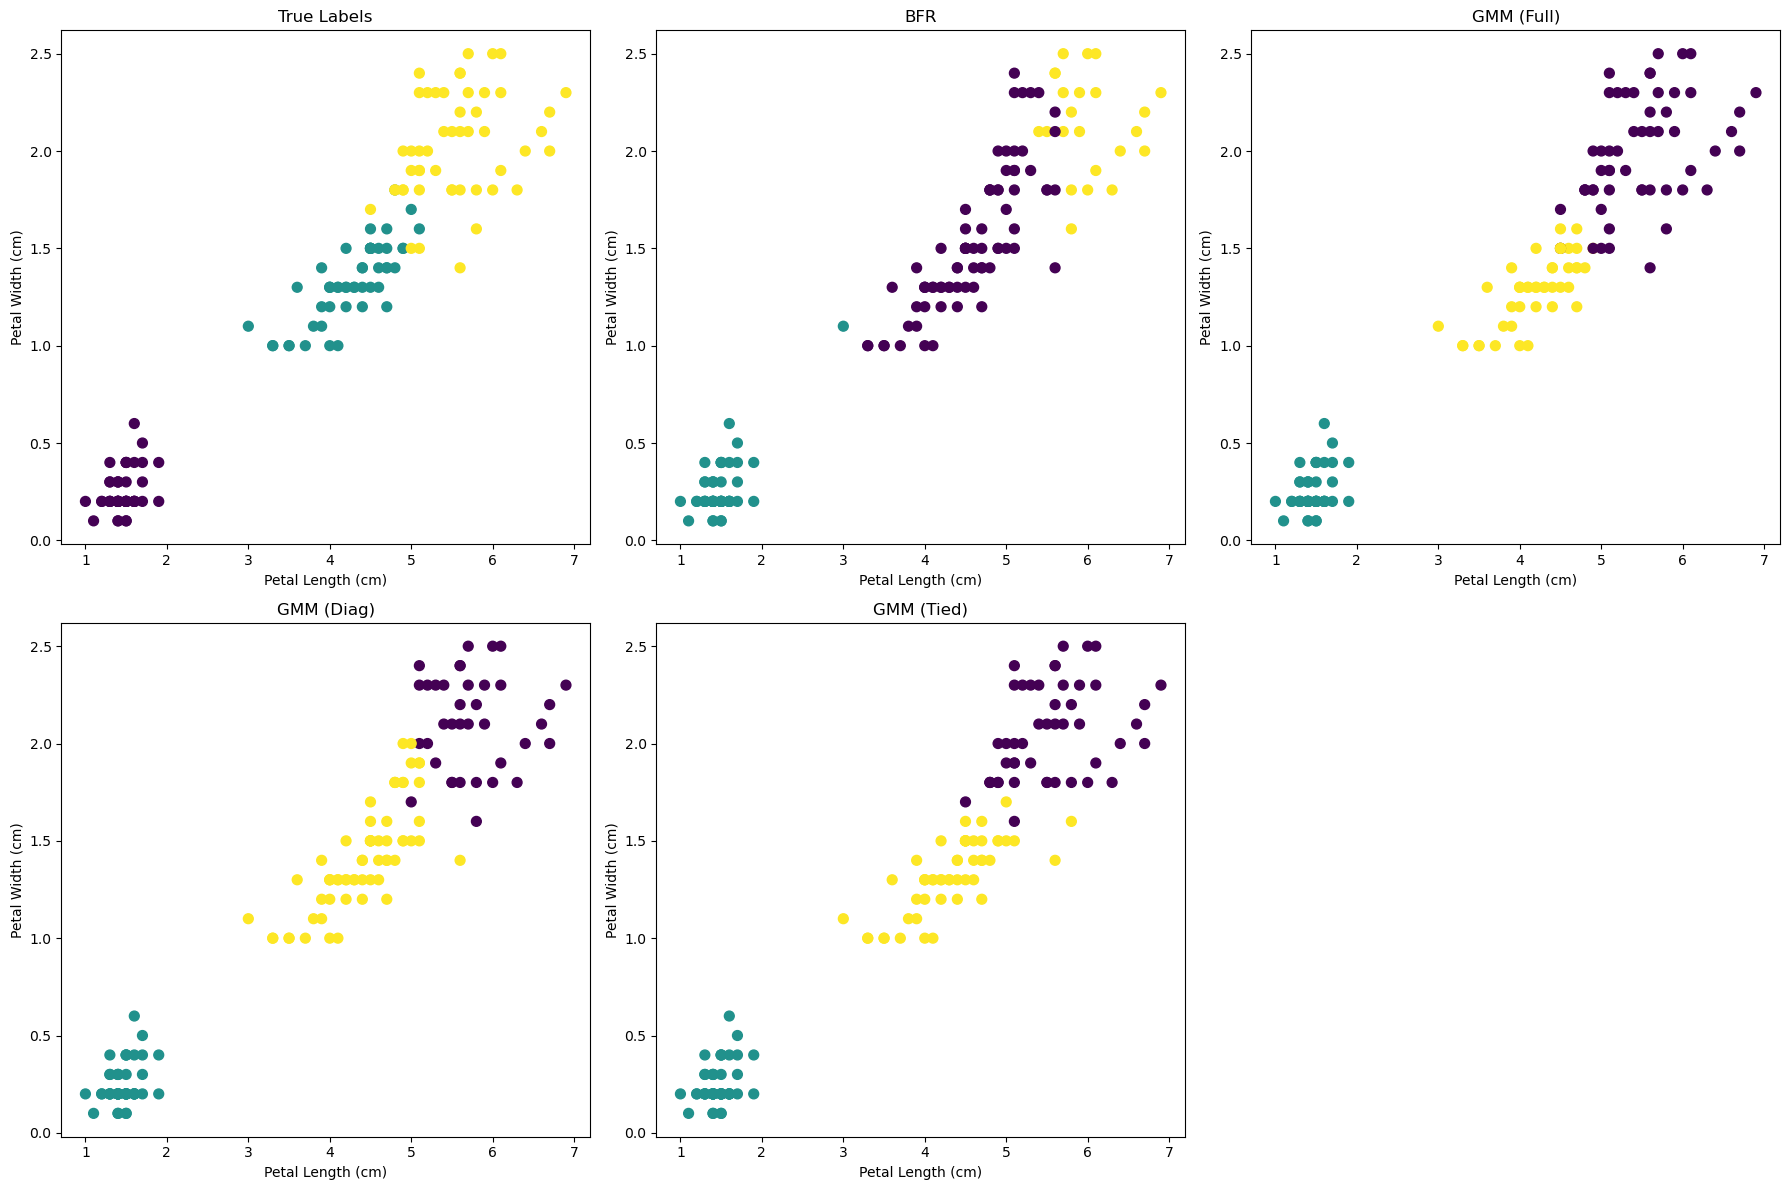

In [9]:
petal_length = X['petal length (cm)'].values
petal_width = X['petal width (cm)'].values

clustering_results = {
    'True Labels': y,
    'BFR': bfr_labels,
    'GMM (Full)': gmm_results['full']['Labels'],
    'GMM (Diag)': gmm_results['diag']['Labels'],
    'GMM (Tied)': gmm_results['tied']['Labels']
}

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (title, labels) in enumerate(clustering_results.items()):
    ax = axes[idx]
    scatter = ax.scatter(petal_length, petal_width, c=labels, cmap='viridis', s=50)
    ax.set_title(title)
    ax.set_xlabel('Petal Length (cm)')
    ax.set_ylabel('Petal Width (cm)')

for ax in axes[len(clustering_results):]: fig.delaxes(ax)

plt.tight_layout()
plt.show()

# Aufgabe 3

Teildatensätze clustern und als CS verwenden, um dann damit das finale Clustering zu erstellen.

Weitere Elaboration sollte nicht nötig sein.